### Author: [Pratik Sharma](https://github.com/sharmapratik88/)
## Project 11 - Natural Language Processing - Sarcasm Detection
**Problem Statement**
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

**Dataset Description**
News Headlines dataset for Sarcasm Detection. The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets: Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embedding. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets. Unlike tweets that reply to other tweets, the news headlines obtained are self- contained. This would help us in teasing apart the real sarcastic elements Content Each record consists of three attributes: 
- `is_sarcastic`: 1 if the record is sarcastic otherwise 0
- `headline`: the headline of the news article
- `article_link`: link to the original news article. Useful in collecting supplementary data

**Acknowledgement**

Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

### Import Packages

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/Great Learning/NLP/Sarcasm Detection/')

In [3]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Text preprocessing and stopwords
from text_preprocess import * #(custom module)

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

!rm -R log/

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Loading Dataset

In [4]:
data = pd.read_json('./Data/Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 26709 rows and 3 columns. Here are the first five rows of the data...


article_link  ... is_sarcastic
0  https://www.huffingtonpost.com/entry/versace-b...  ...            0
1  https://www.huffingtonpost.com/entry/roseanne-...  ...            0
2  https://local.theonion.com/mom-starting-to-fea...  ...            1
3  https://politics.theonion.com/boehner-just-wan...  ...            1
4  https://www.huffingtonpost.com/entry/jk-rowlin...  ...            0

[5 rows x 3 columns]

------------------------------------------------------------
Value Counts for `is_sarcastic` label
------------------------------------------------------------
Is Sarcastic count: 11724 i.e. 44.0%
Isn't Sarcastic count: 14985 i.e. 56.0%
------------------------------------------------------------
Distributon of `is_sarcastic` label
------------------------------------------------------------


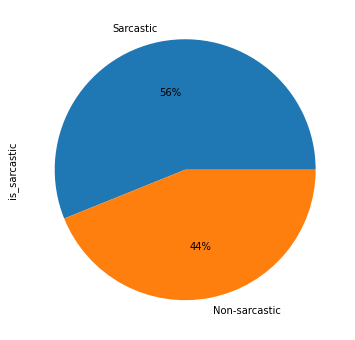

In [5]:
print('--'*30); print('Value Counts for `is_sarcastic` label'); print('--'*30)
print(f'Is Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e. {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Isn\'t Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e. {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

print('--'*30); print('Distributon of `is_sarcastic` label'); print('--'*30)
_ = data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

In [6]:
print('Analysis of `is_sarcastic` label by news website'); print('--'*30)

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))

Analysis of `is_sarcastic` label by news website
------------------------------------------------------------


huffingtonpost  theonion
Sarcastic                   0     11724
Non-sarcastic           14985         1

In [7]:
# Checking 5 random headlines and labels from the data
print('--'*30); print('Checking 5 random headlines and labels from the data'); print('--'*30)
rands = random.sample(range(1, data.shape[0]), 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

------------------------------------------------------------
Checking 5 random headlines and labels from the data
------------------------------------------------------------
Headline: chromat features not 1, but 2 plus-size models on its runway
label: 0

Headline: documentary about grisly murder inspires dozens of copycat documentaries
label: 1

Headline: breakup doesn't seem to have changed relationship
label: 1

Headline: 3 myths about low libido
label: 0

Headline: man calls trust fund savings
label: 1



------------------------------------------------------------
Checking 5 random headlines and labels from the data where the length of headline is > 100
------------------------------------------------------------
Headline: paul ryan confident american people will warm up to tax plan once they realize life a cruel and meaningless farce
label: 1

Headline: 'zero dark thirty' reveals navy seals killed bin laden by frantically throwing whatever they could find at him
label: 1

Headline: skipping out on friend's birthday party at last minute closest woman will ever come to feeling rush of heroin
label: 1

Headline: melania trump hangs decayed badger carcass over white house mantel to finish off traditional slovenian christmas decor
label: 1

Headline: ornithologist forced to participate in history channel's 'what if humans suddenly became birds?' program
label: 1

------------------------------------------------------------
Distributon of label where the length of headline is > 100
--------

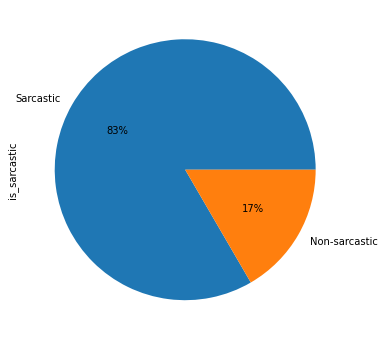

In [8]:
# Checking 5 random headlines and labels from the data where the length of headline is > 100
print('--'*30); print('Checking 5 random headlines and labels from the data where the length of headline is > 100'); print('--'*30)
indexes = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
rands = random.sample(indexes, 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

print('--'*30); print('Distributon of label where the length of headline is > 100'); print('--'*30)
_ = data.loc[indexes, 'is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

#### **Observation**
* 44% of the data have sarcastic labels whereas 56% don't.
* Suprising! There are no headlines from HuffPost that are sarcastic whereas all but one from The Onion are sarcastic.
* Based on some random headlines seen above, it appears that the data is mostly lower-cased. Pre-processing such as removing punctuations and lemmatization can be used.
* There are digits in the headlines for e.g. `3 things i needed to hear when i weighed 300 pounds` where removing the digits wouldn't help.
* 83% of data where length of sentence (headlines) > 100 are sarcastic headlines.

### Drop `article_link` from dataset.

In [9]:
print('Dropping `article_link` from the data'); print('--'*30)
data.drop('article_link', axis = 1, inplace = True)

Dropping `article_link` from the data
------------------------------------------------------------


### Data Preprocessing
Few of the data pre-processing steps taken before applying model on the data

* Converting to lower case, avoid any capital cases
* Converting apostrophe to the standard lexicons
* Removing punctuations
* Lemmatization

In [10]:
print('--'*30); print('Converting headlines to lower case')
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : replace_words(x))

print('Removing punctuations')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_punctuation(x))

print('Applying Lemmatizer')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))

# print('Removing stopwords')
# data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_stopwords(x))
print('--'*30)

------------------------------------------------------------
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Applying Lemmatizer
Removing multiple spaces between words
------------------------------------------------------------


### Get the Length of each line and find the maximum length
As different lines are of different length. We need to pad the our sequences using the max length.

In [11]:
print('--'*40); print('Get the length of each line, find the maximum length and print the maximum length line'); 
print('Length of line ranges from 7 to 241.'); print('--'*40)
# Get length of each line
data['line_length'] = data['cleaned_headline'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print('Line with maximum length: {}'.format(data[data['line_length'] == data['line_length'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the length of each line, find the maximum length and print the maximum length line
Length of line ranges from 7 to 241.
--------------------------------------------------------------------------------
Minimum line length: 7
Maximum line length: 241
Line with maximum length: maya angelou poet author civil right activist and—holy cow—tony award–nominated actress college professor magazine editor streetcar conductor—really streetcar conductor wow—calypso singer nightclub performer and foreign journalist dead at 86


In [12]:
print('--'*40); print('Get the number of words, find the maximum number of words and print the maximum number of words'); 
print('Number of words ranges from 2 to 39.'); print('--'*40)
# Get length of each line
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))
print('Line with maximum number of words: {}'.format(data[data['nb_words'] == data['nb_words'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the number of words, find the maximum number of words and print the maximum number of words
Number of words ranges from 2 to 39.
--------------------------------------------------------------------------------
Minimum number of words: 2
Maximum number of words: 39
Line with maximum number of words: elmore leonard modern prose master noted for his terse prose style and for writing about thing perfectly and succinctly with a remarkable economy of word unfortunately and sadly expired this gloomy tuesday at the age of 87 year old


Word Cloud of Sarcastic and Non-sarcastic Headlines


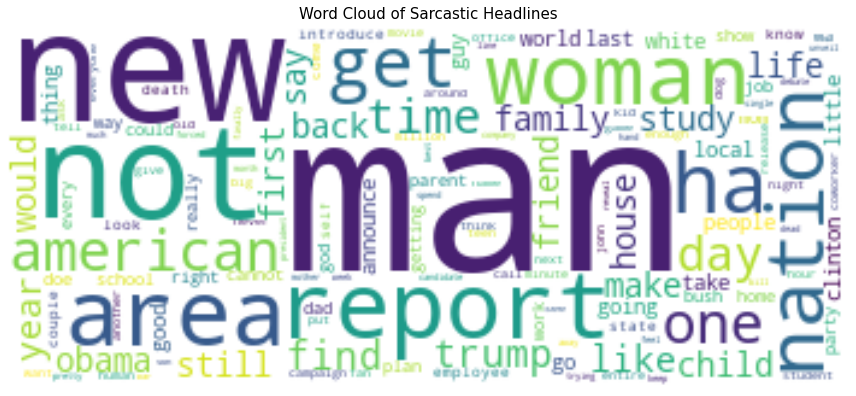

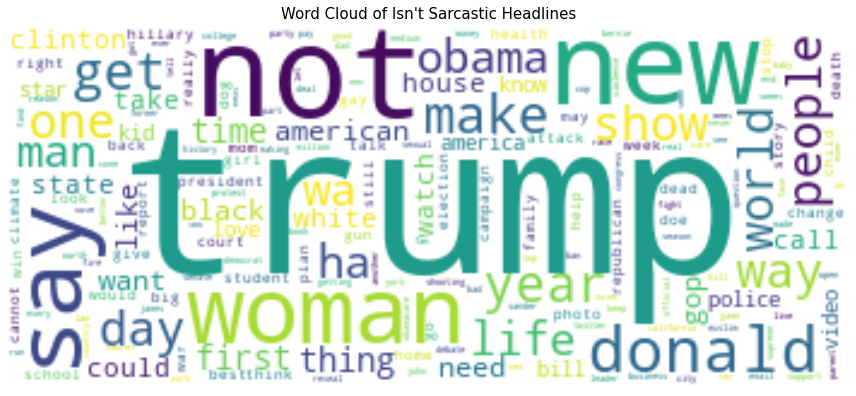

In [13]:
print('Word Cloud of Sarcastic and Non-sarcastic Headlines')
data['headline'] = data['headline'].fillna('')
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
plot_wordcloud(sarcastic_headlines, title = 'Word Cloud of Sarcastic Headlines')

non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])
plot_wordcloud(non_sarcastic_headlines, title = 'Word Cloud of Isn\'t Sarcastic Headlines')

### Modelling

In [14]:
print('--'*30); print('Five point summary for number of words')
display(data['nb_words'].describe().round(0).astype(int)); 

print('99% quantilie: {}'.format(data['nb_words'].quantile(0.99)));print('--'*30)

------------------------------------------------------------
Five point summary for number of words


count    26709
mean        10
std          3
min          2
25%          8
50%         10
75%         12
max         39
Name: nb_words, dtype: int64

99% quantilie: 18.0
------------------------------------------------------------


#### Set Different Parameters for the model

In [0]:
max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 200

### Applying Keras Tokenizer 

In [0]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

### Define X and y for your model.

In [17]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of Samples: 26709
Number of Labels: 26709

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  327  686 2924 1254   54  291  107 1915    6 2014 3610]

Label of the first headline: 0


### Get the Vocabulary size

In [18]:
# Reserve padding (indexed zero)
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 24962


### Word Embedding

#### Get Glove Word Embeddings

In [0]:
glove_file = './Data/glove.6B.zip'

In [0]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

#### Get word embeddings using embedding file

In [0]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

#### Create a weight matrix

In [22]:
# Getting the minimum number of words
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

### Create and Compile Model
* Split the data into train, valid and test set so that it's easy to compare and evaluate
* Use Sequential model instance
* Add Embedding layer
* Bidirectional(LSTM) layer
* GlobalMaxPool1D layer
* Dense, dropout layers
* Add a final dense layer with sigmoid activation for binary classification

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

------------------------------------------------------------ 
Number of rows in training dataset: 21367
Number of columns in training dataset: 39
Number of unique words in training dataset: 9959
------------------------------------------------------------ 
Number of rows in test dataset: 5342
Number of columns in test dataset: 39
Number of unique words in test dataset: 7397


In [24]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)  
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [es, mc, lr_r, tb]

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 200)           2000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 39, 256)           336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

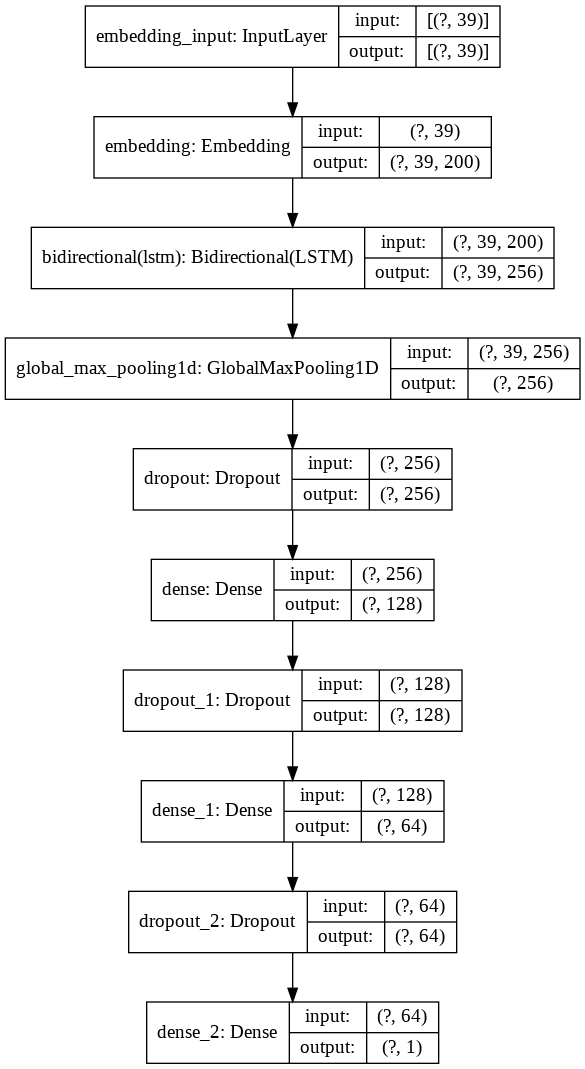

In [25]:
tf.keras.utils.plot_model(model, show_shapes = True)

### Fitting model
* Setting batch_size = 100 and epoch = 2

In [26]:
batch_size = 100
epochs = 6

h = model.fit(x_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

Epoch 1/6

Epoch 00001: val_loss improved from inf to 0.45601, saving model to sarcasm_detector.h5
171/171 - 5s - loss: 0.6003 - accuracy: 0.6652 - val_loss: 0.4560 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 2/6

Epoch 00002: val_loss improved from 0.45601 to 0.37185, saving model to sarcasm_detector.h5
171/171 - 4s - loss: 0.4396 - accuracy: 0.8054 - val_loss: 0.3719 - val_accuracy: 0.8329 - lr: 0.0010
Epoch 3/6

Epoch 00003: val_loss improved from 0.37185 to 0.35007, saving model to sarcasm_detector.h5
171/171 - 4s - loss: 0.3802 - accuracy: 0.8364 - val_loss: 0.3501 - val_accuracy: 0.8425 - lr: 0.0010
Epoch 4/6

Epoch 00004: val_loss improved from 0.35007 to 0.33750, saving model to sarcasm_detector.h5
171/171 - 4s - loss: 0.3344 - accuracy: 0.8583 - val_loss: 0.3375 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 5/6

Epoch 00005: val_loss improved from 0.33750 to 0.32761, saving model to sarcasm_detector.h5
171/171 - 4s - loss: 0.3032 - accuracy: 0.8754 - val_loss: 0.3276 - val_accuracy:

In [27]:
%load_ext tensorboard
%tensorboard --logdir log/

<IPython.core.display.Javascript object>

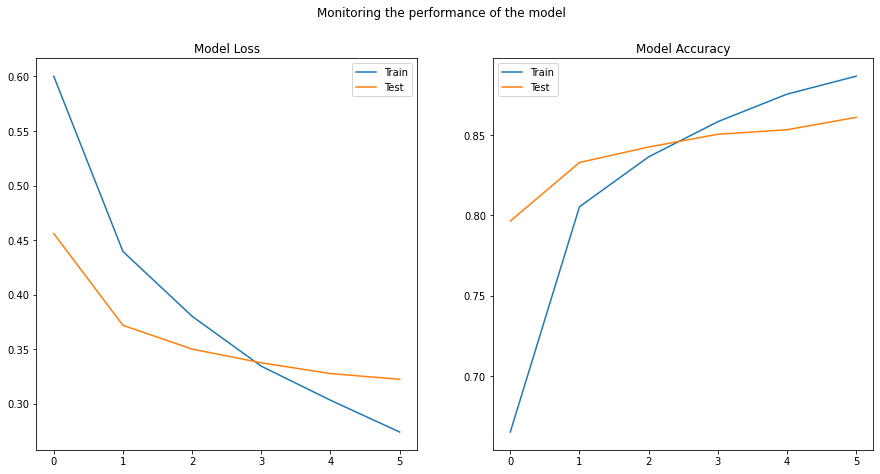

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Monitoring the performance of the model')

ax1.plot(h.history['loss'], label = 'Train')
ax1.plot(h.history['val_loss'], label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])

ax2.plot(h.history['accuracy'], label = 'Train')
ax2.plot(h.history['val_accuracy'], label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])

plt.show()

In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 86.0


In [30]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2972
           1       0.85      0.84      0.84      2370

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



------------------------------------------------------------
Confusion Matrix


Non-sarcastic  Sarcastic
Non-sarcastic           2611        385
Sarcastic                361       1985

------------------------------------------------------------


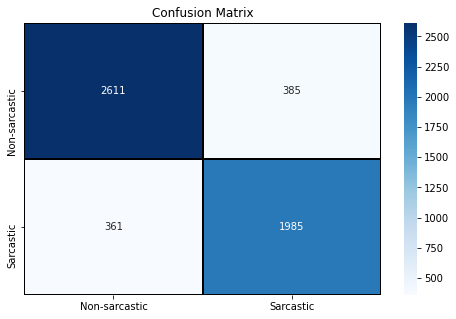

In [31]:
print('--'*30); print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); print('--'*30)

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'Blues', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

In [32]:
print('Evaluate model on sample sarcastic lines'); print('--'*30)
statements = ['Are you always so stupid or is today a special ocassion?', #Sarcasm
              'I feel so miserable without you, it\'s almost like having you here.', #Sarcasm
              'If you find me offensive. Then I suggest you quit finding me.', #Sarcasm
              'If I wanted to kill myself I would climb your ego and jump to your IQ.', #Sarcasm
              'Amphibious pitcher makes debut', #Sarcasm
              'It\'s okay if you don\'t like me. Not everyone has good taste.' #Sarcasm
              ]

for statement in statements:
  statement = statement.lower()
  statement = replace_words(statement)
  statement = remove_punctuation(statement)
  statement = lem(statement)
  statement = re.sub(' +', ' ', statement)

  headline = tokenizer.texts_to_sequences(statement)
  headline = pad_sequences(headline, maxlen = maxlen, dtype = 'int32', value = 0)

  sentiment = (model.predict(headline) > 0.5).astype('int32')
  if(np.argmax(sentiment) == 0):
      print(f'`{statement}` is a Non-sarcastic statement.')
  elif (np.argmax(sentiment) == 1):
      print(f'`{statement}` is a Sarcastic statement.')

Evaluate model on sample sarcastic lines
------------------------------------------------------------
`are you always so stupid or is today a special ocassion` is a Sarcastic statement.
`i feel so miserable without you it is almost like having you here` is a Sarcastic statement.
`if you find me offensive then i suggest you quit finding me` is a Sarcastic statement.
`if i wanted to kill myself i would climb your ego and jump to your iq` is a Sarcastic statement.
`amphibious pitcher make debut` is a Sarcastic statement.
`it is okay if you do not like me not everyone ha good taste` is a Sarcastic statement.


### Conclusion
* We used data pre-processing techniques to clean headlines, such as:
  * Converting to lower case
  * Converting to standard lexicons such as it's to it is
  * Remove punctuations
  * Lemmatize
  * Remove multiple spaces
* Some of the observation:
  * 44% of the data have sarcastic labels whereas 56% don't.
  * Suprising! There are no headlines from HuffPost that are sarcastic whereas all but one from The Onion are sarcastic.
  * Based on some random headlines seen above, it appears that the data is mostly lower-cased. Pre-processing such as removing punctuations and lemmatization can be used.
  * There are digits in the headlines for e.g. *3 things i needed to hear when i weighed 300 pounds* where removing the digits wouldn't help.
  * 83% of data where length of sentence (headlines) > 100 are sarcastic headlines.
* Used Glove embedding layer with Bidirectional LSTM layer. Model architecture was also plotted. Also saw how we can use tensorboard to visualize the metrics such as loss and accuracy.
* Created a separate training and test sets; while fitting the model kept aside a 0.2 for validation;
* Model achieved 86% accuracy on the test set; classification report and confusion matrix were also printed.
* Model was also evaluated on some sample sarcastic statements and did well in identifying all them as sarcasm.